In [30]:
# Helpers
import pickle
import numpy as np

# Plot
import matplotlib.pyplot as plt

### Analying distribution from SUNY dataset

In [2]:
folder = "data/suny/"

In [5]:
with open("%s/1_train_test.pkl" % folder, "rb") as pklfile:
    data = pickle.load(pklfile)

In [16]:
data.keys()

dict_keys(['num_users', 'num_attempts', 'num_quizs', 'num_disicussions', 'train', 'test', 'cross_train', 'cross_validation'])

In [56]:
total = 0
for i, fold in enumerate(data["cross_train"]):
    total += len(fold)
    print("Fold %d has %d items" % (i, len(fold)))

Fold 0 has 5715 items
Fold 1 has 5625 items
Fold 2 has 5661 items
Fold 3 has 5682 items


In [71]:
total = 0
cross_train_items = []
repeated_cross_train_items = []
for i, fold in enumerate(data["cross_train"]):
    for row in fold:
        # Check if row is not in train or if it was repeated
        if row not in data["train"] and row not in data["test"]:
            if row not in cross_train_items:
                cross_train_items.append(row)
            else:
                repeated_cross_train_items.append(row)

In [76]:
total = 0
cross_test_items = []
repeated_cross_test_items = []
for i, fold in enumerate(data["cross_validation"]):
    for row in fold:
        # Check if row is not in train or if it was repeated
        if row not in data["train"] and row not in data["test"]:
            if row not in cross_test_items:
                cross_test_items.append(row)
            else:
                repeated_cross_test_items.append(row)

In [57]:
total = 0
for i, fold in enumerate(data["cross_validation"]):
    total += len(fold)
    print("Fold %d has %d items" % (i, len(fold)))

Fold 0 has 527 items
Fold 1 has 617 items
Fold 2 has 581 items
Fold 3 has 560 items


In [20]:
students_train_list = [item[0] for item in data["train"]]
students_train_set = set(students_train_list)

print("Total of %d items in train belonging to %d different students" % (len(students_train_list), 
                                                                         len(students_train_set)))

Total of 4682 items in train belonging to 458 different students


In [21]:
students_test_list = [item[0] for item in data["test"]]
students_test_set = set(students_test_list)

print("Total of %d items in train belonging to %d different students" % (len(students_test_list), 
                                                                         len(students_test_set)))

Total of 439 items in train belonging to 71 different students


In [22]:
common_students = students_train_set & students_test_set
len(common_students)

71

In [43]:
only_train = students_train_set - students_test_set

In [46]:
# Number of attempts from test students in train set
attempts_train = []
attempts_test = []
for student in students_test_set:
    attempts_train.append(students_train_list.count(student))
    attempts_test.append(students_test_list.count(student))
    
# Number of attempts from train students in train set
attempts_all_train = []
for student in students_train_set:
    attempts_all_train.append(students_train_list.count(student))
    
# Number of attempts from train students in train set that are not in test set
attempts_only_train = []
for student in only_train:
    attempts_only_train.append(students_train_list.count(student))

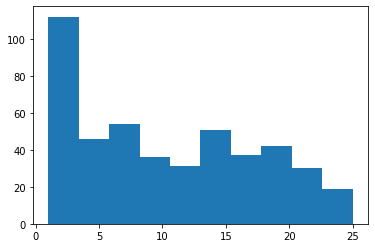

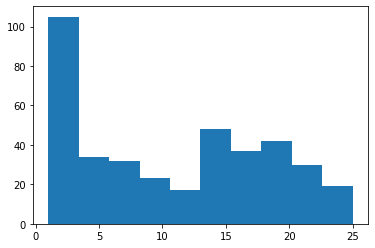

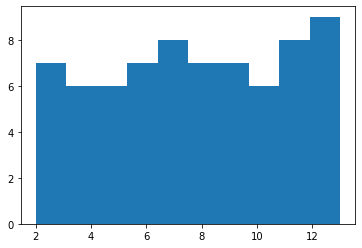

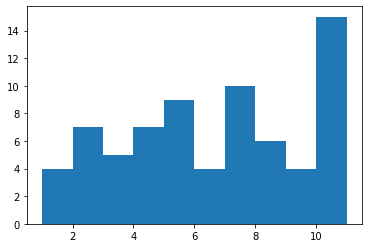

In [47]:
plt.hist(attempts_all_train)
plt.show()

plt.hist(attempts_only_train)
plt.show()

plt.hist(attempts_train)
plt.show()

plt.hist(attempts_test)
plt.show()

### Retrieving my data

In [161]:
from django.db.models import Case, IntegerField, Value

In [393]:
attempts = UserLog.objects.filter(timestamp__lt=OuterRef('timestamp'), 
                                           user__id=OuterRef('user__id')).annotate(attempt=Count('*')+1
                                                                                  ).values('attempt')

# Remove group by values
attempts.query.set_group_by()

In [394]:
# Get users (students who have started this semester with lab exercises)
users = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).values_list("user__id", "problem", "attempt", "score", #"outcome", "timestamp"
                                                                    ).order_by("timestamp").filter(attempt=1).values('user_id')

In [395]:
problems = Problem.objects.exclude(chapter=None)
solutions = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).values_list("user__id", "problem", "attempt", "score", #"outcome", "timestamp"
                                                                    ).order_by("timestamp").filter(user__in=users)

In [400]:
users.count()

119

In [398]:
solutions.count()

18447

In [ ]:
ufrj_dataset = {}
ufrj_dataset["num_users"] = users.count()
#ufrj_dataset["num_attempts"] = users.count()
ufrj_dataset["num_problems"] = problems.count()
#ufrj_dataset[""]